In [1]:
import numpy as np
import rasterio as rs
import hickle as hkl
import os
import hickle as hkl
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd



In [2]:
x = pd.read_csv("../../src/asia_grid.csv")
x = x[x['country'] == 'Australia']
x.reset_index(inplace = True)
x.to_csv("../../src/australia.csv")

In [3]:
x.shape

(229518, 6)

25.93117198335645


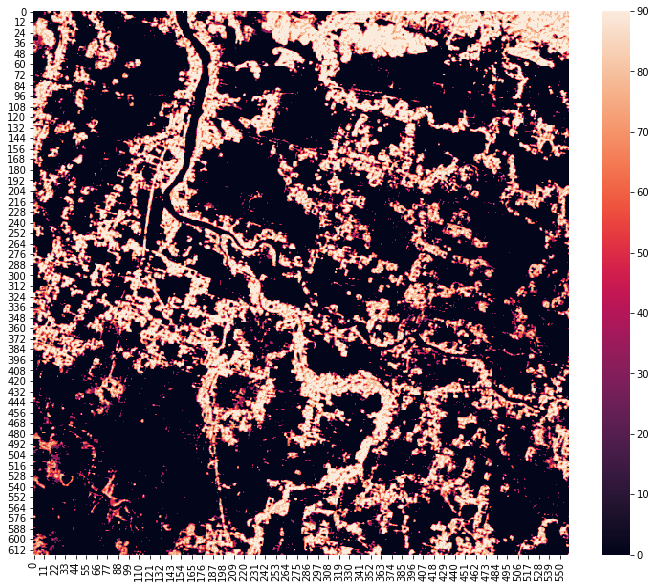

In [18]:
import numpy as np
import scipy

x = rs.open("5714X1349Y_FINAL.tif").read(1)
plt.figure(figsize=(12,10))
sns.heatmap(x)
print(np.mean(x))

In [ ]:
from sklearn.neighbors import kneighbors_graph
import networkx

nb = kneighbors_graph(x, n_neighbors = 3)
g = networkx.from_scipy_sparse_matrix(nb)
l = networkx.k_core(g)
l = networkx.to_numpy_array(l)



In [23]:
def Func(a):
    a = np.sum(a > 40) #np.sum((a > 5) & (a < 40))
    return a


%time xmax = scipy.ndimage.generic_filter(x, Func, 3)

CPU times: user 2.3 s, sys: 10.1 ms, total: 2.31 s
Wall time: 2.32 s


<AxesSubplot:>

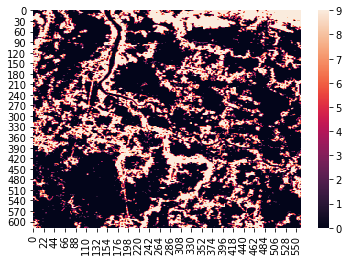

In [24]:
sns.heatmap(xmax)

<AxesSubplot:>

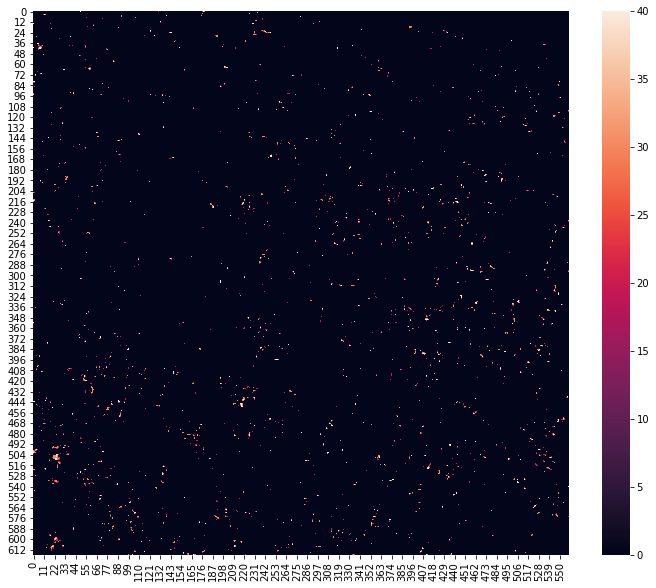

In [25]:
xnew = np.copy(x)
xnew[xmax < 1 ] = 0.
plt.figure(figsize=(12,10))
sns.heatmap(x - xnew)

<AxesSubplot:>

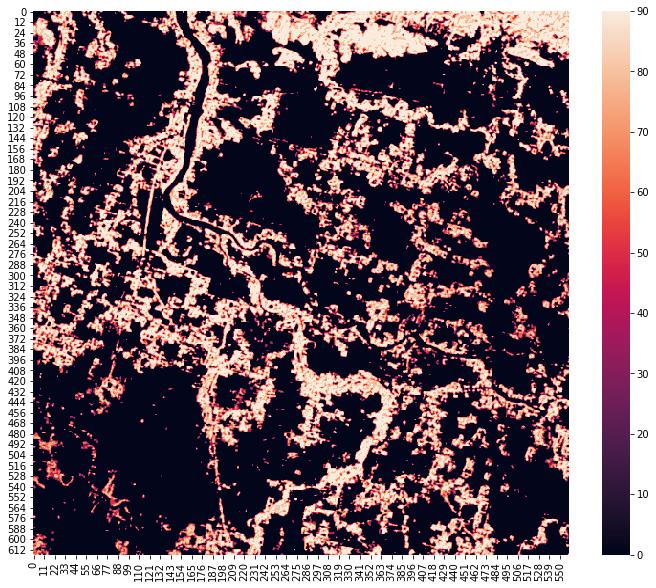

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(xnew)